RIght, so in this notebook we are going to investigating the feasibility of predicting household income band from smart meter data by training transformer neural networks on the IDEAL dataset.

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load survey responses
survey = pd.read_csv('/Users/eoghan/repos/makemore/data/survey_responses.csv')

In [3]:
# which columns relate to income?
cols = survey.columns[survey.columns.str.contains('income')]
cols 

Index(['income_band_mid', 'income_change_initial',
       'incomeband_certainty_initial'],
      dtype='object')

In [4]:
# what are the unique values in income_band_mid 
survey['income_band_mid'].unique()

array([nan, '£43,200 to £48,599', '£48,600 to £53,999',
       '£54,000 to £65,999', '£13,500 to £16,199', '£27,000 to £32,399',
       '£32,400 to £37,799', '£66,000 to £77,999', 'less than £10,800'],
      dtype=object)

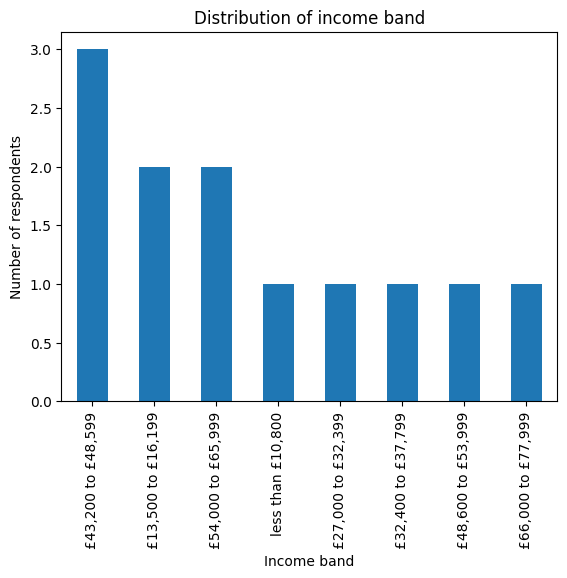

In [5]:
# we want to plot the distribution of income_band_mid, however we want to order the x-axis by the income_band_mid values
# we can do this by converting the income_band_mid column to a category and specifying the order of the categories
survey['income_band_mid_cat'] = survey['income_band_mid'].astype('category')
# the possible values are '£43,200 to £48,599', '£48,600 to £53,999',      '£54,000 to £65,999', '£13,500 to £16,199', '£27,000 to £32,399',        '£32,400 to £37,799', '£66,000 to £77,999', 'less than £10,800'
# we can specify the order of the categories as follows
survey['income_band_mid_cat'] = survey['income_band_mid_cat'].cat.reorder_categories(['less than £10,800', '£13,500 to £16,199', '£27,000 to £32,399', '£32,400 to £37,799', '£43,200 to £48,599', '£48,600 to £53,999', '£54,000 to £65,999', '£66,000 to £77,999'])
# now we can plot the distribution of income_band_mid
survey['income_band_mid_cat'].value_counts().plot(kind='bar')
plt.xlabel('Income band')
plt.ylabel('Number of respondents')
plt.title('Distribution of income band')
plt.show()

There's only 12 responses. That's not really enough to work with. 

In [6]:
# okay it was the wrong data file
survey = pd.read_csv('/Users/eoghan/repos/makemore/data/home.csv')
cols = survey.columns[survey.columns.str.contains('income')]
cols 

Index(['income_band', 'equivalised_income'], dtype='object')

In [7]:
# what are the unique values in income_band
survey['income_band'].unique()

array(['Missing', '£90,000 or more', '£48,600 to £53,999',
       '£43,200 to £48,599', '£66,000 to £77,999', '£54,000 to £65,999',
       '£27,000 to £32,399', 'less than £10,800', '£37,800 to £43,199',
       '£23,400 to £26,999', '£16,200 to £19,799', '£32,400 to £37,799',
       '£78,000 to £89,999', '£13,500 to £16,199', '£10,800 to £13,499',
       '£19,800 to £23,399'], dtype=object)

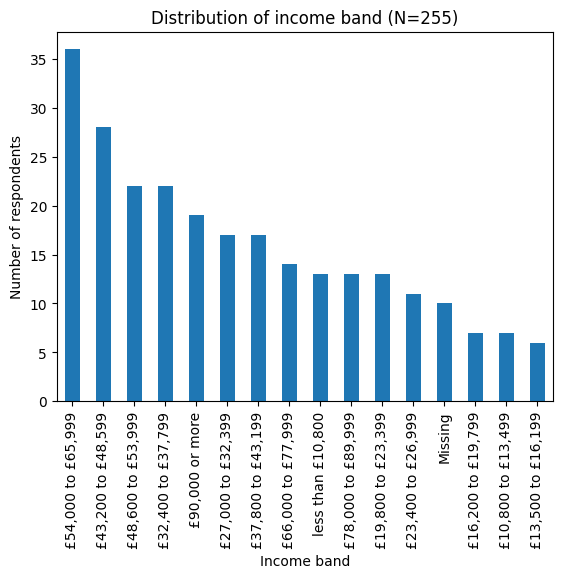

In [9]:
survey['income_band'].value_counts().plot(kind='bar')
plt.xlabel('Income band')
plt.ylabel('Number of respondents')
# what is the total number of non missing values in the income_band column?
total_responses = survey['income_band'].count()
plt.title('Distribution of income band (N={})'.format(total_responses))
plt.show()

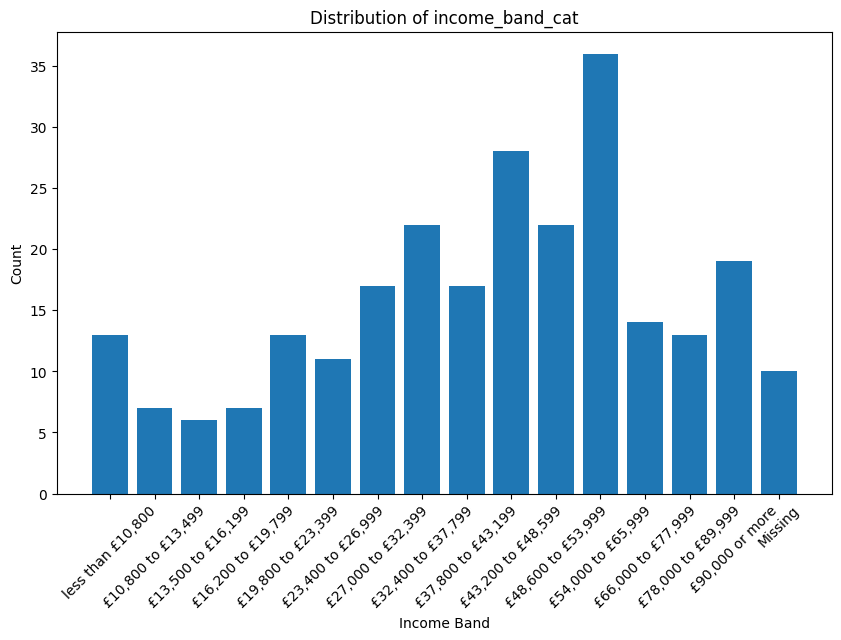

In [13]:
# let's plot this out but in order of the income bands
survey['income_band_cat'] = survey['income_band'].astype('category')
survey['income_band_cat'] = survey['income_band_cat'].cat.reorder_categories(['less than £10,800', '£10,800 to £13,499', '£13,500 to £16,199', '£16,200 to £19,799', '£19,800 to £23,399', '£23,400 to £26,999', '£27,000 to £32,399', '£32,400 to £37,799', '£37,800 to £43,199', '£43,200 to £48,599', '£48,600 to £53,999', '£54,000 to £65,999', '£66,000 to £77,999', '£78,000 to £89,999', '£90,000 or more','Missing'])
# now we want to plot the distribution of income_band_cat but keep the order of the categories
# Assuming df is your DataFrame and 'income_band_cat' is your categorical column
counts = survey['income_band_cat'].value_counts(sort=False)

plt.figure(figsize=(10,6))
plt.bar(counts.index, counts.values)
plt.title('Distribution of income_band_cat')
plt.xlabel('Income Band')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Add this line
plt.show()


Okay, so we've got 255 to work with. This is more like it. So this is going to be the target variable. the input variable(s) are going to be the same as used in the encoder-dual-decoder model. However let's just start with the most simple, and use electricity as the input.

# Hyperparameters

In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import numpy as np

# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 300
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 8
n_head = 1
n_layer_do = 1 # number of decoder only layers
# n_layer_ca = 1 # number of cross-attention layers
dropout = 0.1

torch.manual_seed(1338)

# Data preprocessing

In [15]:
# get the data
data = pd.read_csv('/Users/eoghan/repos/makemore/data/daily_demand_and_weather.csv')
# TODO: add <S> start of sequence token at each change of household_id, and align encoder context data with target, not input tokens
# to start, we will just work with the gas data, later we will complexify things by adding in electricity and weather, and information about the calender day
raw_gas = data['mean_rounded_gas_pulse'].copy()
raw_elec = data['mean_rounded_electric_combined'].copy()

# set all values less than 0 to 0
raw_gas.loc[raw_gas < 0] = 0
raw_elec.loc[raw_elec < 0] = 0

# set unreasonably high values to Nan
raw_gas.loc[raw_gas > 100000] = np.nan
raw_elec.loc[raw_elec > 100000] = np.nan

# so let's simplify the dataset, and round raw_gas to the nearest 10, just to reduce the size of our vocabulary. 
raw_gas = raw_gas.round(-1)
raw_elec = raw_elec.round(-1)

# first however we need to deal with missing values, in particular we need to replace any nan with a special character <M> which will represent missing values
raw_gas = raw_gas.astype(str).replace('nan', '<M>')
raw_elec = raw_elec.astype(str).replace('nan', '<M>')

#create a mapping from values to indices
unique_values_gas = raw_gas.unique()
vocab_size_gas = len(unique_values_gas)
unique_values_gas.sort()
vtoi_gas = {val:i for i, val in enumerate(unique_values_gas)}
itov_gas = {i:val for i, val in enumerate(unique_values_gas)}
encode_gas = lambda v: [vtoi_gas[val] for val in v] # take a list of values and return a list of indices
decode_gas = lambda l: [itov_gas[i] for i in l] # take a list of indices and return a list of values
data_gas = torch.tensor(encode_gas(raw_gas), dtype=torch.long)

# let's split the data into train and validation splits 0.9 / 0.1
#n = int(0.9*len(data_gas))
n = int(0.1*len(data_gas))
train_data_gas = data_gas[n:]
val_data_gas = data_gas[:n]

# and let's do the same for raw_elec
unique_values_elec = raw_elec.unique()
vocab_size_elec = len(unique_values_elec)
unique_values_elec.sort()
vtoi_elec = {val:i for i, val in enumerate(unique_values_elec)}
itov_elec = {i:val for i, val in enumerate(unique_values_elec)}
encode_elec = lambda v: [vtoi_elec[val] for val in v] # take a list of values and return a list of indices
decode_elec = lambda l: [itov_elec[i] for i in l] # take a list of indices and return a list of values
data_elec = torch.tensor(encode_elec(raw_elec), dtype=torch.long)
n = int(0.1*len(data_elec))
train_data_elec = data_elec[n:]
val_data_elec = data_elec[:n]

# add in contextual data, starting with the minimum temperature
# first we need to deal with missing values, in particular we need to replace any nan with a special character <M> which will represent missing values
data['mintemp'] = data['mintemp'].astype(str).replace('nan', '<M>')
unique_values_mintemp = data['mintemp'].unique()
vocab_size_mintemp = len(unique_values_mintemp)
unique_values_mintemp.sort()
vtoi_mintemp = {val:i for i, val in enumerate(unique_values_mintemp)}
itov_mintemp = {i:val for i, val in enumerate(unique_values_mintemp)}
encode_mintemp = lambda v: [vtoi_mintemp[val] for val in v] # take a list of values and return a list of indices
decode_mintemp = lambda l: [itov_mintemp[i] for i in l] # take a list of indices and return a list of values
data_mintemp = torch.tensor(encode_mintemp(data['mintemp']), dtype=torch.long)
n = int(0.1*len(data_mintemp))
train_data_mintemp = data_mintemp[n:]
val_data_mintemp = data_mintemp[:n]


In [24]:
# now we need to create the array of income data
# we want to join the two dataframes on household_id for data and homeid for survey
# we will use the household_id from the data dataframe
# we will use the homeid from the survey dataframe
# we will use the income_band from the survey dataframe
joined = data.merge(survey[['homeid','income_band_cat']], left_on='household_id', right_on='homeid')
# let's check that the join worked
joined.head()

,household_id,datetime,maxtemp,mintemp,conditions,day_of_week,is_weekend,is_bank_holiday,mean_rounded_gas_pulse,mean_rounded_electric_combined,homeid,income_band_cat
0,100,2017-03-07,10.0,4.0,Chance of Rain,1.0,False,False,5277.0,343.0,100,"£27,000 to £32,399"
1,100,2017-03-08,11.0,5.0,Chance of Rain,2.0,False,False,6832.0,253.0,100,"£27,000 to £32,399"
2,100,2017-03-09,11.0,3.0,Chance of Rain,3.0,False,False,1283.0,203.0,100,"£27,000 to £32,399"
3,100,2017-03-10,10.0,7.0,Overcast,4.0,False,False,4168.0,222.0,100,"£27,000 to £32,399"
4,100,2017-03-11,13.0,6.0,Chance of Rain,5.0,True,False,1264.0,243.0,100,"£27,000 to £32,399"


In [26]:
# now we create a torch tensor of the income data similar to the other data arrays
raw_income = joined['income_band_cat'].copy()
unique_values_income = raw_income.unique()
vocab_size_income = len(unique_values_income)
vtoi_income = {val:i for i, val in enumerate(unique_values_income)}
itov_income = {i:val for i, val in enumerate(unique_values_income)}
encode_income = lambda v: [vtoi_income[val] for val in v] # take a list of values and return a list of indices
decode_income = lambda l: [itov_income[i] for i in l] # take a list of indices and return a list of values
data_income = torch.tensor(encode_income(raw_income), dtype=torch.long)

In [35]:
# one complication however is that when splitting data into train and test sets, we cannot do this arbitrarily
# instead we need to split on the household_id, so that all data from a given household is either in the train or test set
# we can do this by creating a hash of the household_id and using this to split the data
# the way to do this is to randomly select household ids and to assign 90% to the train set and 10% to the test set
import numpy as np

household_ids = joined['household_id'].unique()

# Generate a random permutation of indices
perm = np.random.permutation(len(household_ids))

# Split the permuted indices into train and test indices
split_idx = int(len(household_ids) * 0.9)  # 90% of the data for training
train_idx = perm[:split_idx]
test_idx = perm[split_idx:]
# Get the household ids for the train and test sets
train_ids = household_ids[train_idx]
test_ids = household_ids[test_idx]
# and create train and test datasets
train_df = joined[joined['household_id'].isin(train_ids)]
test_df = joined[joined['household_id'].isin(test_ids)]


In [36]:
# now we need to recreate the gas, elec, mintemp and income data arrays for train and test
raw_gas_train = train_df['mean_rounded_gas_pulse'].copy()
raw_gas_train.loc[raw_gas_train < 0] = 0
raw_gas_train.loc[raw_gas_train > 100000] = np.nan
raw_gas_train = raw_gas_train.round(-1)
raw_gas_train = raw_gas_train.astype(str).replace('nan', '<M>')
data_gas_train = torch.tensor(encode_gas(raw_gas_train), dtype=torch.long)

raw_gas_test = test_df['mean_rounded_gas_pulse'].copy()
raw_gas_test.loc[raw_gas_test < 0] = 0
raw_gas_test.loc[raw_gas_test > 100000] = np.nan
raw_gas_test = raw_gas_test.round(-1)
raw_gas_test = raw_gas_test.astype(str).replace('nan', '<M>')
data_gas_test = torch.tensor(encode_gas(raw_gas_test), dtype=torch.long)

raw_elec_train = train_df['mean_rounded_electric_combined'].copy()
raw_elec_train.loc[raw_elec_train < 0] = 0
raw_elec_train.loc[raw_elec_train > 100000] = np.nan
raw_elec_train = raw_elec_train.round(-1)
raw_elec_train = raw_elec_train.astype(str).replace('nan', '<M>')
data_elec_train = torch.tensor(encode_elec(raw_elec_train), dtype=torch.long)

raw_elec_test = test_df['mean_rounded_electric_combined'].copy()
raw_elec_test.loc[raw_elec_test < 0] = 0
raw_elec_test.loc[raw_elec_test > 100000] = np.nan
raw_elec_test = raw_elec_test.round(-1)
raw_elec_test = raw_elec_test.astype(str).replace('nan', '<M>')
data_elec_test = torch.tensor(encode_elec(raw_elec_test), dtype=torch.long)

raw_mintemp_train = train_df['mintemp'].copy()
raw_mintemp_train = raw_mintemp_train.astype(str).replace('nan', '<M>')
data_mintemp_train = torch.tensor(encode_mintemp(raw_mintemp_train), dtype=torch.long)

raw_mintemp_test = test_df['mintemp'].copy()
raw_mintemp_test = raw_mintemp_test.astype(str).replace('nan', '<M>')
data_mintemp_test = torch.tensor(encode_mintemp(raw_mintemp_test), dtype=torch.long)

raw_income_train = train_df['income_band_cat'].copy()
data_income_train = torch.tensor(encode_income(raw_income_train), dtype=torch.long)

raw_income_test = test_df['income_band_cat'].copy()
data_income_test = torch.tensor(encode_income(raw_income_test), dtype=torch.long)



# Data loading

In [37]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x (elec) and targets y (income)
    data = data_elec_train if split == 'train' else data_elec_test
    ix = torch.randint(len(data) - block_size, (batch_size,)) # ix max value is len(data) - block_size - 1
    x_elec = torch.stack([data[i:i+block_size] for i in ix]) # max index is len(data) - 1
    x_elec = x_elec.to(device)
    
    # now do the same for income
    data = data_income_train if split == 'train' else data_income_test
    y_income = torch.stack([data[i:i+block_size] for i in ix]) # same index as x_elec as we want to predct the income for the given day
    y_income = y_income.to(device)
    
    return x_elec, y_income

# Neural network functions and classes

In [38]:
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X_elec, Y_income = get_batch(split)
            logits_income, loss_income = model(X_elec, Y_income)
            losses[k] = loss_income.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
class MaskedHead(nn.Module):
    """ one head of masked self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [ ]:
class Head(nn.Module):
    """ one head of unmasked self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        # wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [ ]:
class MaskedCrossAttentionHead(nn.Module):
    """ one head of masked cross-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, q, kv):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = q.shape
        k = self.key(kv)   # (B,T,hs)
        q = self.query(q) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(kv) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([MaskedHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class MultiHeadEncoderAttention(nn.Module):
    """ multiple heads of unmasked self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out
    
class MultiHeadCrossAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([MaskedCrossAttentionHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, kv):
        out = torch.cat([h(x, kv) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class DecoderOnlyBlock(nn.Module):
    """ Decoder only transformer block: self-communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class EncoderOnlyBlock(nn.Module):
    """ Encoder transformer block: self-communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadEncoderAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
    
class DecoderWithCrossAttentionBlock(nn.Module):
    """ Decoder with cross attention transformer block: self plus corss communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ca = MultiHeadCrossAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln_kv = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.ln3 = nn.LayerNorm(n_embd)

    def forward(self, x, kv):
        # first masked self-attention layer with pre norm and residual connection
        x = x + self.sa(self.ln1(x))
        # cross attention layer with pre norm and residual connection
        x = x + self.ca(self.ln2(x), self.ln_kv(kv))
        x = x + self.ffwd(self.ln3(x))
        return x

In [40]:
class DecoderModel(nn.Module):

    def __init__(self):
        super().__init__()
        # self.token_embedding_gas = nn.Embedding(vocab_size_gas, n_embd)
        self.token_embedding_elec = nn.Embedding(vocab_size_elec, n_embd)
        # self.position_embedding_gas = nn.Embedding(block_size, n_embd)
        self.position_embedding_elec = nn.Embedding(block_size, n_embd)
        # self.do_blocks_gas = nn.Sequential(*[DecoderOnlyBlock(n_embd, n_head=n_head) for _ in range(n_layer_do)])
        self.do_blocks_elec = nn.Sequential(*[DecoderOnlyBlock(n_embd, n_head=n_head) for _ in range(n_layer_do)])
        # TODO: develop sequential cross attention blocks that allow multiple input arguments
        # self.ca_blocks_gas = nn.Sequential(*[DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) for _ in range(n_layer_ca)])
        # self.ca_blocks_elec = nn.Sequential(*[DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) for _ in range(n_layer_ca)])
        # self.ca_blocks_gas = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) 
        # self.ca_blocks_elec = DecoderWithCrossAttentionBlock(n_embd, n_head=n_head) 
        # self.ln_f_gas = nn.LayerNorm(n_embd) # final layer norm
        self.ln_f_elec = nn.LayerNorm(n_embd) # final layer norm
        # self.lm_head_gas = nn.Linear(n_embd, vocab_size_gas)
        self.lm_head_elec = nn.Linear(n_embd, vocab_size_income)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx_elec, targets_income=None):
        B, T = idx_elec.shape 

        # idx_elec and targets_gas are both (B,T) tensor of integers
        # embedding and positional encoding layers
        # tok_emb_gas = self.token_embedding_gas(idx_gas) # (B,T,C)
        tok_emb_elec = self.token_embedding_elec(idx_elec) # (B,T,C)
        # pos_emb_gas = self.position_embedding_gas(torch.arange(T, device=device)) # (T,C)
        pos_emb_elec = self.position_embedding_elec(torch.arange(T, device=device)) # (T,C)
        # x_gas = tok_emb_gas + pos_emb_gas # (B,T,C)
        x_elec = tok_emb_elec + pos_emb_elec # (B,T,C)
        # decoder only layers
        # x_gas = self.do_blocks_gas(x_gas) # (B,T,C)
        x_elec = self.do_blocks_elec(x_elec) # (B,T,C)
        # cross attention layers
        # x_gas = self.ca_blocks_gas(x_gas, x_elec) # (B,T,C)
        # x_elec = self.ca_blocks_elec(x_elec, x_gas) # (B,T,C)
        # final output layers
        # x_gas = self.ln_f_gas(x_gas) # (B,T,C)
        x_elec = self.ln_f_elec(x_elec) # (B,T,C)
        # logits_gas = self.lm_head_gas(x_gas) # (B,T,vocab_size)
        logits_income = self.lm_head_elec(x_elec) # (B,T,vocab_size_income)

        if targets_income is None:
            loss_income = None
        else:
            B, T, C = logits_income.shape
            logits_income = logits_income.view(B*T, C)
            targets_income = targets_income.view(B*T)
            loss_income = F.cross_entropy(logits_income, targets_income)
        return logits_income, loss_income

    def generate(self, idx_elec):
        # Get the length of idx_elec
        elec_length = idx_elec.size(1) 
        # Initialize an empty tensor to store the income band predictions
        income_band_preds = torch.empty((idx_elec.size(0), 0), dtype=torch.long, device=idx_elec.device)

        # Iterate over the length of elec_length
        for i in range(0, elec_length, block_size):
            idx_elec_block = idx_elec[:, i:i+block_size]

            # Get the predictions, but only for the last time step
            logits_income_band, _ = self(idx_elec_block)
            logits_income_band = logits_income_band[:, -1, :] # becomes (B, vocab_size_income)

            # Apply softmax to get probabilities
            probs_income_band = F.softmax(logits_income_band, dim=-1)

            # Get the class with the highest probability
            income_band = torch.argmax(probs_income_band, dim=-1)

            # Append the predictions for the current block to income_band_preds
            income_band_preds = torch.cat((income_band_preds, income_band), dim=1)

        return income_band_preds


In [ ]:
# TODO: the generate function is not working in the same way as the forward training...generate is basicaly producing one classificatoin 
# for the entire sequence, rather than a classification for each time step in the sequence, yet the loss is being calculated for each time step in the sequence
